# Numerical Methods for Approximating the Error Function

\begin{equation*}
	\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt
\end{equation*}

We seek a method or methods of evaluating the error function which result in a global maximum error smaller than $10 \varepsilon_{\text{mach}}$, where $\varepsilon = 2.22 \times 10^{-16}$ is the machine accuracy.

In [1]:
import math
import sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import mpmath as mp

import error as e

We use a higher precision floating point approximation ```mpmath.erf(x)``` as a standard to compute realized errors. This ensures that we don't round errors to zero which would actually be $10^{-17}$ for example.

In [2]:
mp.mp.dps = 50

eps = np.finfo(float).eps
TOL = 10 * sys.float_info.epsilon  # ~2.22e-15

In [3]:
v_erf_taylor = np.vectorize(e.erf_taylor)
v_erfc_asymptotic = np.vectorize(e.erfc_asymptotic)
v_erf_pade = np.vectorize(e.erf_pade)
v_erf_gauss_legendre = np.vectorize(e.erf_gauss_legendre)
v_erf_adaptive_gauss_legendre = np.vectorize(e.erf_adaptive_gauss_legendre)
v_erf_gk15 = np.vectorize(e.erf_adaptive_gk15)
v_hybrid_series = np.vectorize(e.series_hybrid)
v_hybrid2 = np.vectorize(e.hybrid_v2)
v_erf_mp = np.vectorize(mp.erf)

## Taylor Series

\begin{equation*}
	\text{erf}(x) = \frac{2}{\sqrt{\pi}} \sum_{n = 0}^{\infty} \frac{(-1)^n x^{2n+1}}{n! (2n + 1)}
\end{equation*}

In [4]:
x_taylor = np.linspace(0, 10, 1000, dtype=np.float64)

actual_taylor = v_erf_mp(x_taylor)

# Fails entirely for large x due to overflow
taylor_errors = {}
trial_N = np.arange(5, 100, 5)
taylor_boundaries = []

for N in trial_N:
	with warnings.catch_warnings():
		warnings.simplefilter("ignore", RuntimeWarning)
		taylor_approx = v_erf_taylor(x_taylor, tol=0, max_iter=N)
		
	taylor_abs_error = np.maximum(np.abs(actual_taylor - taylor_approx), eps)
	taylor_errors[N] = taylor_abs_error

	# First x where the error exceeds TOL
	bad = np.argwhere(taylor_abs_error > TOL)
	taylor_boundaries.append(
		float(np.squeeze(x_taylor[bad][0])) if len(bad) else np.inf
	)

In [5]:
for N, boundary in zip(trial_N, taylor_boundaries):
	print(f"N = {N}:".ljust(10), f"Boundary = {boundary:.4f}")

N = 5:     Boundary = 0.0901
N = 10:    Boundary = 0.4805
N = 15:    Boundary = 0.9209
N = 20:    Boundary = 1.3514
N = 25:    Boundary = 1.7417
N = 30:    Boundary = 2.1021
N = 35:    Boundary = 2.1922
N = 40:    Boundary = 2.1922
N = 45:    Boundary = 2.1922
N = 50:    Boundary = 2.1922
N = 55:    Boundary = 2.1922
N = 60:    Boundary = 2.1922
N = 65:    Boundary = 2.1922
N = 70:    Boundary = 2.1922
N = 75:    Boundary = 2.1922
N = 80:    Boundary = 2.1922
N = 85:    Boundary = 2.1922
N = 90:    Boundary = 2.1922
N = 95:    Boundary = 2.1922


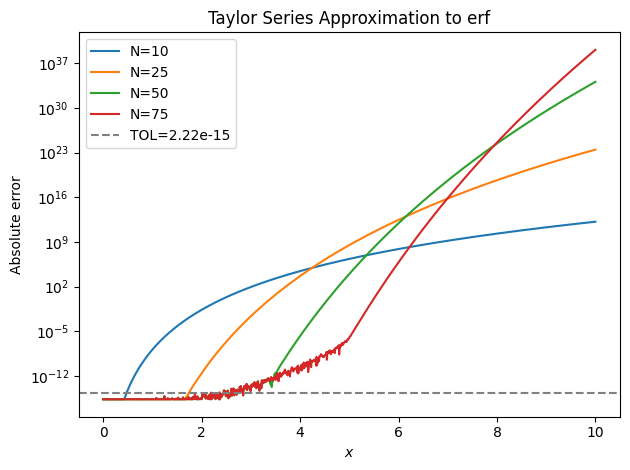

In [6]:
fig, ax = plt.subplots()

for N in [10, 25, 50, 75]:
	ax.plot(x_taylor, taylor_errors[N], label=f"N={N}")

ax.axhline(TOL, color="grey", linestyle="--", label=f"TOL={TOL:.2e}")

ax.set_yscale("log", base=10)
ax.set_title("Taylor Series Approximation to erf")
ax.set_xlabel("$x$")
ax.set_ylabel("Absolute error")
ax.legend();
fig.tight_layout()

fig.savefig("taylor_error.pdf")

Using just 25 terms in the summation, the Taylor series achieves an absolute error less than $10 \varepsilon_{\text{mach}}$ for $x \lesssim 1.7$.  Each additional batch of terms extends the accurate region by a modest amount, but even 75 terms fails for $x > 3$. The series converges for all $x$ in exact arithmetic, but the intermediate terms grow large before cancelling. The resulting catastrophic cancellation limits practical accuracy in double precision. We therefore need complementary methods for larger $x$.

## Asymptotic Series for Complementary Error Function

\begin{equation*}
	\text{erfc}(x) = \frac{e^{-x^2}}{x\sqrt{\pi}} \left( 1 + \sum_{n=1}^{N - 1} (-1)^n \frac{1 \cdot 3 \cdot 5 \cdots (2n - 1)}{(2x^2)^n} \right) + \varepsilon_N(x),
\end{equation*}

where 

\begin{equation*}
	|\varepsilon_N(x)| \leq \frac{e^{-x^2}}{x\sqrt{\pi}} \frac{1 \cdot 3 \cdot 5 \cdots (2N - 1)}{(2x^2)^N} 
\end{equation*}

The error term does not go to zero as $N \rightarrow 0$ for any fixed $x$. 

Optimal $N = \lfloor x^2 + 0.5 \rfloor$ for $x \geq 4$. 

In [7]:
x_asymp = np.linspace(1, 20, 1000, dtype=np.float64)

actual_asymp = v_erf_mp(x_asymp)
asymptotic_approx = 1 - v_erfc_asymptotic(x_asymp)
asymptotic_abs_error = np.maximum(np.abs(actual_asymp - asymptotic_approx), eps)

In [8]:
bad_idx = np.argwhere(asymptotic_abs_error > TOL)
boundary_asymp = float(np.squeeze(x_asymp[bad_idx])[-1]) if len(bad_idx) else 1.0
boundary_asymp

3.9479479479479482

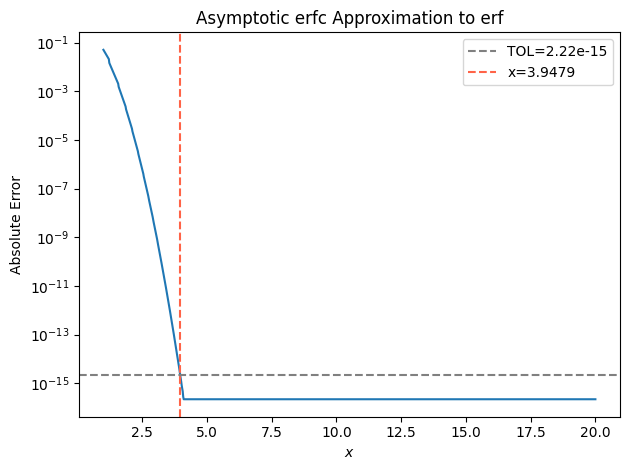

In [9]:
fig, ax = plt.subplots()

ax.semilogy(x_asymp, asymptotic_abs_error)
ax.axhline(TOL, linestyle="--", color="grey", label=f"TOL={TOL:.2e}")
ax.axvline(boundary_asymp, linestyle="--", color="tomato", label=f"x={boundary_asymp:.4f}")

ax.set_ylabel("Absolute Error")
ax.set_xlabel("$x$")
ax.legend()
ax.set_title("Asymptotic erfc Approximation to erf");
fig.tight_layout();

In [10]:
large_x = np.linspace(6, 1000000, 10000)

actual_large = v_erf_mp(large_x)
approx_large = 1- v_erfc_asymptotic(large_x)
large_error = np.abs(actual_large - approx_large)

In [11]:
float(np.max(large_error))

2.1519736712498913e-17

Beyond $x \simeq 6$, the erfc asymptotic series achieves an absolute error less than $\varepsilon_{\text{mach}}$.

## Combining Series Approximations

In [12]:
def taylor_error(x, N=25):
	return (2 * x**(2*N + 3)) / (np.sqrt(np.pi) * math.factorial(N + 1) * (2* N + 3))

def erfc_error(x):
	N = int(math.floor(x*x) + 0.5)
	acc = np.exp(-x*x) / (x * np.sqrt(np.pi))
	for n in range(1, 2*N, 2):
		acc *= n
	acc /= (2*x*x)**N
	
	return acc

v_taylor_error = np.vectorize(taylor_error)
v_erfc_error = np.vectorize(erfc_error)

In [13]:
from scipy.optimize import minimize_scalar

i = minimize_scalar(
	lambda y: np.maximum(np.abs(v_erfc_error(y) - v_taylor_error(y)), eps), 
	bounds=(1.5, 4.0), method="bounded"
)

i.x

np.float64(2.5936389822058157)

In [14]:
v_taylor_error(i.x)

array(4.56840908e-07)

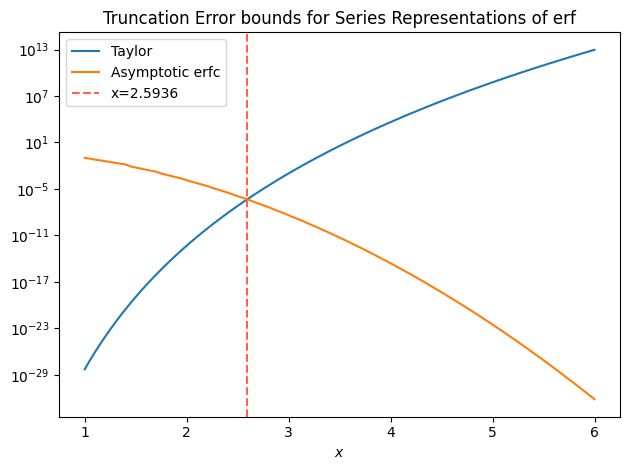

In [15]:
x_error = np.linspace(1, 6, 100)

fig, ax = plt.subplots()

ax.plot(x_error, v_taylor_error(x_error), label="Taylor")
ax.plot(x_error, v_erfc_error(x_error), label="Asymptotic erfc")
ax.axvline(i.x, linestyle="--", color="tomato", label=f"x={i.x:.4f}")

ax.set_yscale('log', base=10)
ax.set_xlabel("$x$")
ax.set_title("Truncation Error bounds for Series Representations of erf")
ax.legend()
fig.tight_layout()

fig.savefig("truncation_bounds.pdf")

In [16]:
actual = v_erf_mp(x_error)

with warnings.catch_warnings():
	warnings.simplefilter("ignore", RuntimeWarning)
	taylor_approx = v_erf_taylor(x_error, tol=TOL)
asymp_approx = 1- v_erfc_asymptotic(x_error)

taylor_abs_error = np.maximum(np.abs(actual - taylor_approx), eps)
asymp_abs_error = np.maximum(np.abs(actual - asymp_approx), eps)

In [17]:
idx = np.squeeze(np.where(taylor_abs_error > asymp_abs_error))[0]

switch = float(x_error[idx])

switch

3.525252525252525

In [18]:
float(taylor_abs_error[idx])

3.2159780435771565e-12

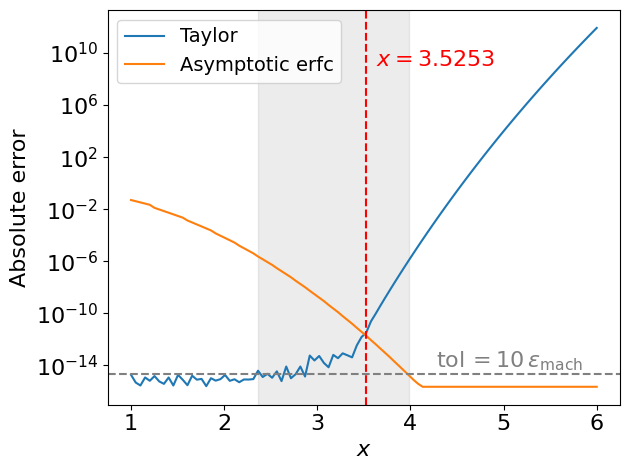

In [19]:
fig, ax = plt.subplots()

ax.plot(x_error, taylor_abs_error, label="Taylor")
ax.plot(x_error, asymp_abs_error, label="Asymptotic erfc")
ax.axvline(switch, linestyle="--", color="red")
ax.axhline(TOL, linestyle="--", color="grey")

xmax = ax.get_xlim()[1]
ax.text(xmax - 0.4, TOL * 1.2,
    r"$\operatorname{tol} = 10\,\varepsilon_{\mathrm{mach}}$",
    ha='right',
    va='bottom',
    fontsize=16,
    color='grey'
)

ax.text(switch + 0.1, 1e9, f"$x={switch:.4f}$", fontsize=16, color='red')

ax.axvspan(x_error[(taylor_abs_error > TOL)][0], x_error[(asymp_abs_error < TOL)][0], alpha=0.15, color='grey')

ax.set_yscale('log', base=10)
ax.set_ylabel("Absolute error", fontsize=16)
ax.set_xlabel("$x$", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=14, loc="upper left")
fig.tight_layout();

# fig.savefig("series_error.pdf")

In [20]:
x_series_hybrid = np.linspace(0, 6, 1000)

actual = v_erf_mp(x_series_hybrid)
with warnings.catch_warnings():
	warnings.simplefilter("ignore", RuntimeWarning)
	hybrid_approx = v_hybrid_series(x_series_hybrid, b=switch)

hybrid_abs_error = np.maximum(np.abs(actual - hybrid_approx), eps)

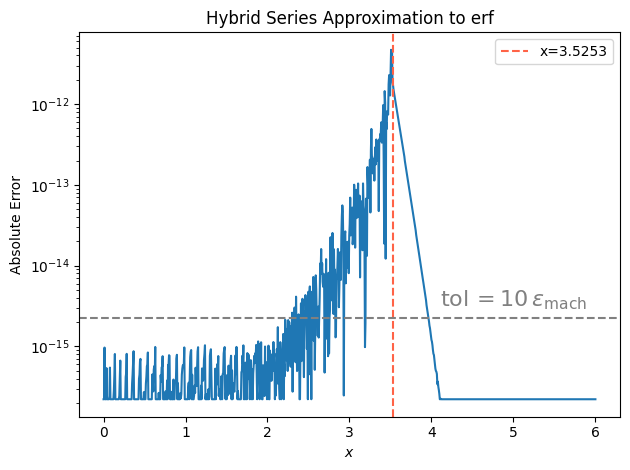

In [21]:
fig, ax = plt.subplots()

ax.plot(x_series_hybrid, hybrid_abs_error)

ax.axvline(switch, linestyle="--", color="tomato", label=f"x={switch:.4f}")
ax.axhline(TOL, linestyle="--", color="grey")

xmax = ax.get_xlim()[1]
ax.text(xmax - 0.4, TOL * 1.2,
    r"$\operatorname{tol} = 10\,\varepsilon_{\mathrm{mach}}$",
    ha='right',
    va='bottom',
    fontsize=16,
    color='grey'
)

ax.set_yscale('log', base=10)
ax.set_ylabel("Absolute Error")
ax.set_xlabel("$x$")
ax.set_title("Hybrid Series Approximation to erf")
ax.legend()
fig.tight_layout()

fig.savefig("series_hybrid.pdf")

Using a hybrid series method we can attain a global maximum absolute error of approximately $10^{-11}$. The problem region occurs between $x \approx 2$ and $x \approx 4$, where neither the Taylor series nor the asymptotic erfc expansion achieves sufficient precision. We now seek alternative methods to fill this gap.

## Padé Approximation

We can approximate a function $f(x)$ with a rational function
\begin{equation*}
	r(x) = \frac{P(x)}{Q(x)}
\end{equation*}

The $[m/n]$ Padé approximation matches the derivatives of $f(x)$ and $r(x)$ evaluated at $x = 0$ up to order $N \coloneqq m + n$. It uses a polynomial of degree $m$ in the numerator and degree $n$ in the denominator, with $Q(0) = 1$.

The denominator coefficients are found by solving an $n \times n$ linear system built from the Taylor coefficients $a_k$. For erf, even-indexed coefficients are zero (erf is odd), so the system has a checkerboard structure that can become ill-conditioned as $m + n$ grows. The condition number of the $[10/10]$ system is $\sim 10^9$, which limits numerical accuracy. Libraries such as Boost and SciPy avoid this by instead using the Remez algorithm to find the minimax rational approximation directly.

In [22]:
x_pade = np.linspace(0, 10, 1000)

actual = v_erf_mp(x_pade)

pade_errors = {}
pade_boundaries = {}

for n in range(2, 51, 4):
	for m in range(1, n, 4):
		try:
			pade_approx = v_erf_pade(x_pade, m, n)
		except Exception:
			pade_errors[(m, n)] = None
		else:
			pade_abs_error = np.maximum(np.abs(actual - pade_approx), eps)
			pade_errors[(m, n)] = pade_abs_error

			bad = np.argwhere(pade_abs_error > TOL)
			pade_boundaries[(m, n)] = float(np.squeeze(x_pade[bad][0])) if len(bad) else np.inf

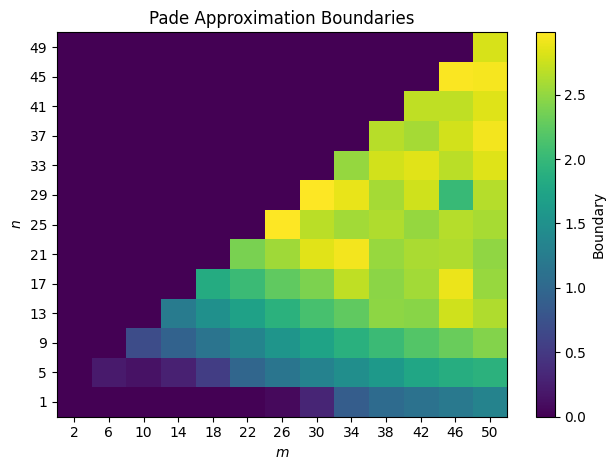

In [23]:
fig, ax = plt.subplots()

# Extract ranges
xs = sorted(set(i for i, j in pade_boundaries))
ys = sorted(set(j for i, j in pade_boundaries))

grid = np.zeros((len(xs), len(ys)))

for (i, j), v in pade_boundaries.items():
	xi = xs.index(i)
	yj = ys.index(j)
	grid[xi, yj] = v

im = ax.imshow(grid, origin="lower", aspect="auto")
fig.colorbar(im, ax=ax, label="Boundary")

ax.set_xticks(range(len(ys)))
ax.set_xticklabels(ys)
ax.set_yticks(range(len(xs)))
ax.set_yticklabels(xs)
ax.set_xlabel("$m$")
ax.set_ylabel("$n$")
ax.set_title("Pade Approximation Boundaries")
fig.tight_layout()

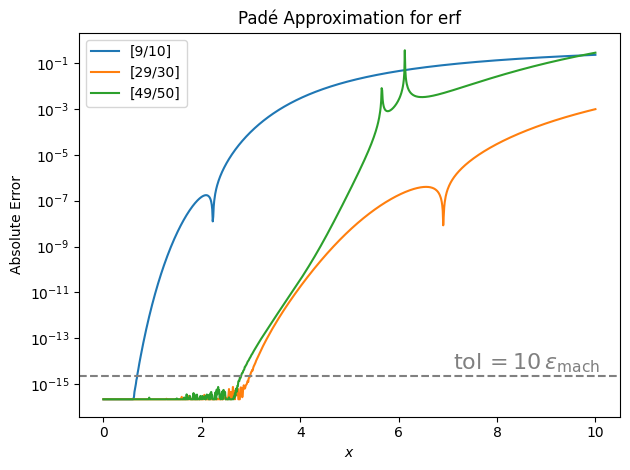

In [24]:
fig, ax = plt.subplots()

for m, n in [(9, 10), (29, 30), (49, 50)]:
	ax.semilogy(x_pade, pade_errors[(m, n)], label=f"[{m}/{n}]")

ax.axhline(TOL, linestyle="--", color="grey")

xmax = ax.get_xlim()[1]
ax.text(xmax - 0.4, TOL * 1.2,
    r"$\operatorname{tol} = 10\,\varepsilon_{\mathrm{mach}}$",
    ha='right',
    va='bottom',
    fontsize=16,
    color='grey'
)

ax.set_ylabel("Absolute Error")
ax.set_xlabel("$x$")
ax.set_title("Padé Approximation for erf")
ax.legend();
fig.tight_layout()

fig.savefig("pade.pdf")

Padé approximation provides better precision for larger values of $x$ than the Taylor series and comparable precision for smaller $x$. Although it outperforms Taylor in the mid-range, the error is still orders of magnitude larger than our target. The ill-conditioning of the coefficient system (condition number $\sim 10^9$ for $[10/10]$) means that simply increasing $m$ and $n$ does not reliably improve accuracy.

## Gauss-Legendre Quadrature

\begin{equation*}
	I \approx \sum_{k=1}^{n} H_k f(x_k),
\end{equation*}
where the pivots $x_k$ ($k = 1, \ldots, n$) are the roots of the $n$-th Legendre polynomial and the weights are
\begin{equation*}
	H_k = \int_{-1}^{1} \ell_k(x)\, dx,
\end{equation*}
with $\ell_k$ the fundamental polynomials of Lagrange interpolation. The rule integrates polynomials of degree up to $2n - 1$ exactly.

Since the error function integral is over $[0, x]$, we map to $[-1, 1]$ via $t = \tfrac{x}{2}(s + 1)$; $dt = \frac{x}{2} ds$ :
\begin{equation*}
	\text{erf}(x) = \frac{x}{\sqrt{\pi}} \int_{-1}^{1} e^{-\left(\frac{x}{2}(s + 1)\right)^2} ds.
\end{equation*}

In [25]:
x_gl = np.linspace(0, 10, 1000)
actual = v_erf_mp(x_gl)
gl_n = np.arange(4, 65, 4)

gl_errors = {}
gl_boundaries = {}

for n in gl_n:
	gauss_legendre_approx = v_erf_gauss_legendre(x_gl, n=n)
	gauss_legendre_abs_error = np.maximum(np.abs(actual - gauss_legendre_approx), eps)
	
	gl_errors[n] = gauss_legendre_abs_error
	bad = np.argwhere(gauss_legendre_abs_error > TOL)
	gl_boundaries[n] = float(np.squeeze(x_gl[bad])[0]) if len(bad) else np.inf

In [26]:
for n in gl_n:
	print(f"n = {n}: Boundary = {gl_boundaries[n]:.4f}")

n = 4: Boundary = 0.1101
n = 8: Boundary = 0.9409
n = 12: Boundary = 2.3924
n = 16: Boundary = 3.9139
n = 20: Boundary = 3.1832
n = 24: Boundary = 6.6767
n = 28: Boundary = 4.5946
n = 32: Boundary = 5.6657
n = 36: Boundary = 4.1041
n = 40: Boundary = 2.8028
n = 44: Boundary = 3.6637
n = 48: Boundary = 2.6627
n = 52: Boundary = 5.1451
n = 56: Boundary = inf
n = 60: Boundary = 2.3824
n = 64: Boundary = 4.4444


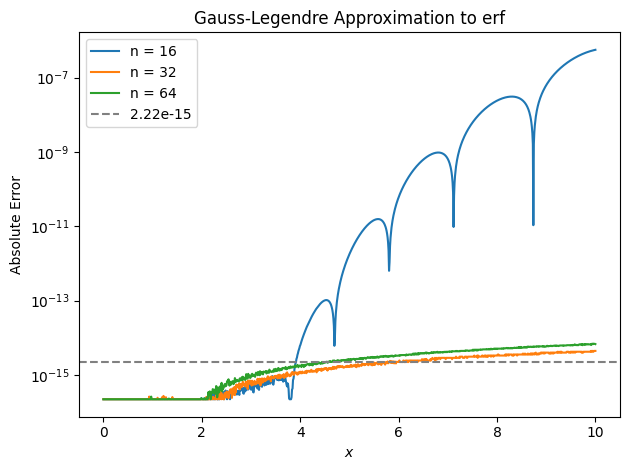

In [27]:
fig, ax = plt.subplots()

for n in [16, 32, 64]:
	ax.semilogy(x_gl, gl_errors[n], label=f"n = {n}")

ax.axhline(TOL, linestyle="--", color="grey", label=f"{TOL:.2e}")

ax.set_ylabel("Absolute Error")
ax.set_xlabel("$x$")

ax.legend()
ax.set_title("Gauss-Legendre Approximation to erf");

fig.tight_layout()

fig.savefig("gl_quadrature.pdf")

This almost fills in the gap between the two series approximations. The error in the region $3.8 \leqslant x \leqslant 4.0$ remains above $10^{-15}$.

## Adaptive Gauss-Legendre Quadrature

The integrand $e^{-t^2}$ decays rapidly so most of the variation is concentrated near $t = 0$. Adaptive quadrature exploits this by refining only where needed.

The scheme bisects $[a, b]$ whenever the difference between the single-panel estimate $Q_{[a,b]}$ and the two half-interval estimates $Q_{[a,m]} + Q_{[m,b]}$ exceeds the local tolerance:

\begin{equation*}
	\left| Q_{[a,b]} - \bigl(Q_{[a,m]} + Q_{[m,b]}\bigr) \right| > \delta.
\end{equation*}

This is analogous to adaptive Simpson's rule but uses $n$-point Gauss–Legendre intervals.

In [28]:
x_agl = np.linspace(0, 10, 1000)

actual = v_erf_mp(x_agl)

adaptive_errors = {}
adaptive_boundaries = {}
adaptive_trial_n = np.arange(3, 12, 1)

for n in adaptive_trial_n:
	adaptive_approx = v_erf_adaptive_gauss_legendre(x_agl, n=n, tol=1e-14)
	adaptive_abs_error = np.maximum(np.abs(adaptive_approx - actual), eps)

	adaptive_errors[n] = adaptive_abs_error
	bad = np.argwhere(adaptive_abs_error > TOL)
	adaptive_boundaries[n] = float(np.squeeze(x_agl[bad])[0]) if len(bad) else np.inf

In [29]:
for n in adaptive_trial_n:
	print(f"n = {n}: Boundary = {adaptive_boundaries[n]}")

n = 3: Boundary = inf
n = 4: Boundary = inf
n = 5: Boundary = inf
n = 6: Boundary = inf
n = 7: Boundary = inf
n = 8: Boundary = inf
n = 9: Boundary = inf
n = 10: Boundary = inf
n = 11: Boundary = inf


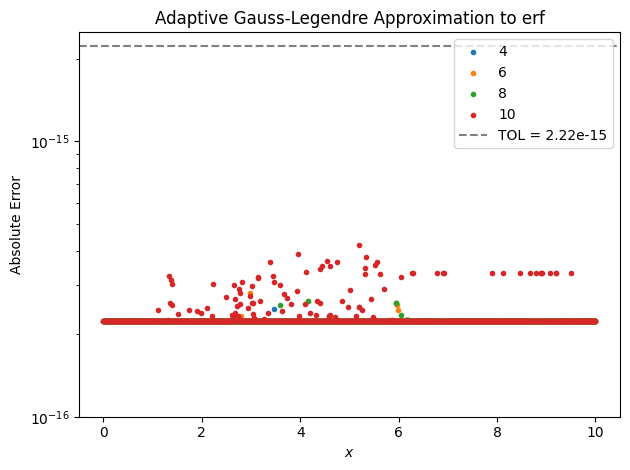

In [30]:
fig, ax = plt.subplots()

for n in [4, 6, 8, 10]:
	ax.scatter(x_agl, adaptive_errors[n], marker='.', label=f"{n}")

ax.axhline(TOL, linestyle="--", color="grey", label=f"TOL = {TOL:.2e}")

ax.set_yscale('log', base=10)
ax.set_ylabel("Absolute Error")
ax.set_xlabel("$x$")
ax.set_title("Adaptive Gauss-Legendre Approximation to erf")
ax.set_ylim(bottom=1e-16)
ax.legend();
fig.tight_layout()

## Gauss-Kronrod Quadrature

The Gauss-Kronrod rule embeds a 7-point Gauss rule inside a 15-point Kronrod extension. The 15 Kronrod nodes are chosen so that the 7 Gauss nodes are a subset, meaning both estimates share all function evaluations.

In [31]:
x_gk = np.linspace(0, 10, 1000)
actual_gk = v_erf_mp(x_gk)
approx_gk = v_erf_gk15(x_gk)
error_gk = np.maximum(np.abs(actual_gk - approx_gk), eps)

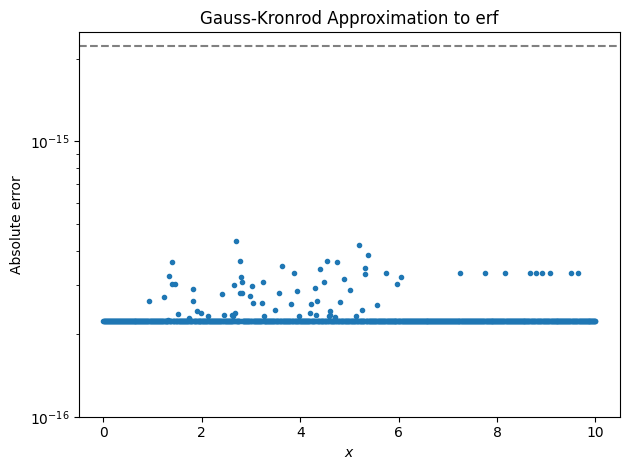

In [32]:
fig, ax = plt.subplots()

ax.scatter(x_gk, error_gk, marker='.')
ax.axhline(TOL, linestyle="--", color="grey", label=f"TOL={TOL:.2e}")

ax.set_yscale('log', base=10)
ax.set_title("Gauss-Kronrod Approximation to erf")
ax.set_ylim(bottom=1e-16)
ax.set_ylabel("Absolute error")
ax.set_xlabel("$x$");
fig.tight_layout()

## Comparing methods so far

In [33]:
x_comp = np.linspace(0, 10, 250)
actual_comp = v_erf_mp(x_comp)

with warnings.catch_warnings():
	warnings.simplefilter("ignore", RuntimeWarning)
	series_hybrid_approx = v_hybrid_series(x_comp, b=switch)
fixed_gl_approx = v_erf_gauss_legendre(x_comp, n=40)
adaptive_quad_approx = v_erf_adaptive_gauss_legendre(x_comp, n=7)
gk_approx = v_erf_gk15(x_comp)

series_hybrid_error = np.maximum(np.abs(actual_comp - series_hybrid_approx), eps)
fixed_gl_error = np.maximum(np.abs(actual_comp - fixed_gl_approx), eps)
adaptive_quad_error = np.maximum(np.abs(actual_comp - adaptive_quad_approx), eps)
gk_error = np.maximum(np.abs(actual_comp - gk_approx), eps)

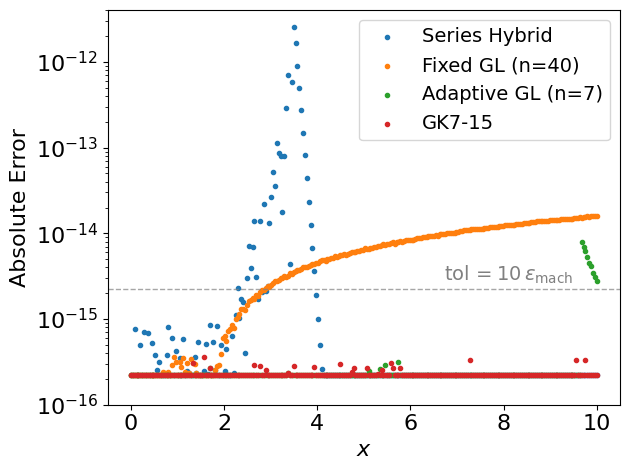

In [34]:
fig, ax = plt.subplots()

ax.scatter(x_comp, series_hybrid_error, label="Series Hybrid", marker=".")
ax.scatter(x_comp, fixed_gl_error, label="Fixed GL (n=40)", marker=".")
ax.scatter(x_comp, adaptive_quad_error, label="Adaptive GL (n=7)", marker=".")
ax.scatter(x_comp, gk_error, label="GK7-15", marker=".")
ax.axhline(TOL, linestyle="--", linewidth=1, color="grey", alpha=0.7)

ax.set_yscale('log', base=10)
ax.set_ylim(bottom=1e-16)
ax.set_ylabel("Absolute Error", fontsize=16)
ax.set_xlabel("$x$", fontsize=16)
ax.tick_params(labelsize=16)

xmax = ax.get_xlim()[1]
ax.text(
    xmax - 1,
    TOL * 1.1,  # slight vertical offset
    r"$\operatorname{tol} = 10\,\varepsilon_{\mathrm{mach}}$",
    ha='right',
    va='bottom',
    fontsize=14,
    color='grey'
)
ax.legend(fontsize=14);
fig.tight_layout()

# fig.savefig("quadrature_comparison.pdf")

Fixed-order GL ($n = 40$) achieves good accuracy for $x < 2$ but wastes evaluations in the flat tail. Both adaptive methods match or exceed its accuracy everywhere. GK7-15 produces a marginally tighter error than adaptive GL for the same tolerance, because its embedded error estimate is more sensitive: it comes free from the same function evaluations rather than requiring an extra panel comparison.

## Final Hybrid Method: Taylor + Adaptive Quadrature + Asymptotic

`hybrid_v2` combines all three approaches into a single function:

| Region | Method |
|--------|--------|
| $x < \alpha$ | Taylor series (cheap, highly accurate for small $x$) |
| $\alpha \leq x < \beta$ | Adaptive GK7-15 ($\text{tol} = 10^{-14}$) |
| $x \geq \beta$ | Asymptotic erfc series (free of quadrature cost for large $x$) |

The boundaries were chosen by examining where each constituent method first achieves better than $10 \varepsilon_{\text{mach}}$ absolute error, minimising total function evaluations while maintaining near-machine-precision accuracy throughout $[0, 10]$.

In [35]:
test_taylor_x = np.linspace(0, 6, 100000)
actual_taylor = v_erf_mp(test_taylor_x)

with warnings.catch_warnings():
	warnings.simplefilter("ignore", RuntimeWarning)
	approx_taylor = v_erf_taylor(test_taylor_x)
	
error_taylor = np.maximum(np.abs(actual_taylor - approx_taylor), eps)

In [36]:
test_taylor_x[np.squeeze(np.where(error_taylor > TOL))[0]]

np.float64(2.080160801608016)

In [37]:
test_asymp_x = np.linspace(1, 10, 100000)
actual_asymp = v_erf_mp(test_asymp_x)

approx_asymp = 1- v_erfc_asymptotic(test_asymp_x)
error_asymp = np.maximum(np.abs(actual_asymp - approx_asymp), eps)

In [38]:
test_asymp_x[np.squeeze(np.where(error_asymp > TOL))[-1]]

np.float64(3.966069660696607)

In [39]:
x = np.linspace(0, 10, 10000)

actual = v_erf_mp(x)

hybrid_approx = v_hybrid2(x, boundary1=2, boundary2=4)
hybrid_abs_error = np.maximum(np.abs(actual - hybrid_approx), eps)

with warnings.catch_warnings():
	warnings.simplefilter("ignore", RuntimeWarning)
	series_hybrid_approx = v_hybrid_series(x, b=switch)
series_hybrid_abs_error = np.maximum(np.abs(actual - series_hybrid_approx), eps)

gk_approx = v_erf_gk15(x)
gk_error = np.maximum(np.abs(actual - gk_approx), eps)

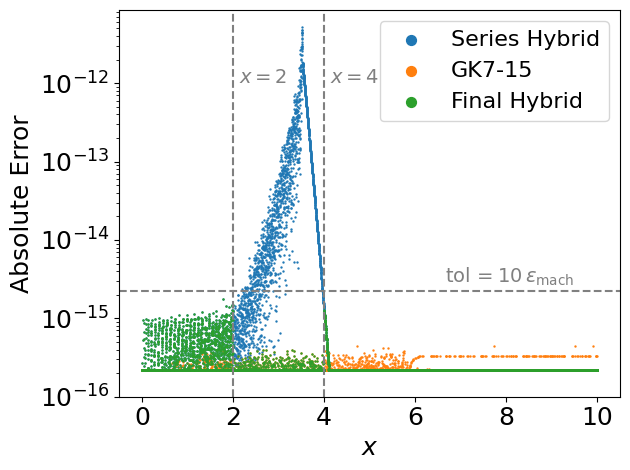

In [40]:
fig, ax = plt.subplots()

ax.scatter(x, series_hybrid_abs_error, marker='.', label="Series Hybrid", s=2)
ax.scatter(x, gk_error, marker=".", label="GK7-15", s=2)
ax.scatter(x, hybrid_abs_error, marker='.', label="Final Hybrid", s=2)
ax.axhline(TOL, linestyle="--", color="grey")

xmax = ax.get_xlim()[1]
ax.text(
    xmax - 1,
    TOL * 1.1,  # slight vertical offset
    r"$\operatorname{tol} = 10\,\varepsilon_{\mathrm{mach}}$",
    ha='right',
    va='bottom',
    fontsize=14,
    color='grey'
)

ax.axvline(2.0, color='grey', linestyle='--')
ax.text(2.0 + 0.12, 1e-12, "$x=2$", fontsize=14, color='grey')

ax.axvline(4.0, color='grey', linestyle='--')
ax.text(4.0 + 0.12, 1e-12, "$x=4$", fontsize=14, color='grey')

ax.set_yscale('log', base=10)
ax.set_ylim(bottom=1e-16)
ax.tick_params(labelsize=18)
ax.set_ylabel("Absolute Error", fontsize=18)
ax.set_xlabel("$x$", fontsize=18)
ax.legend(fontsize=16, markerscale=10)
fig.tight_layout()

# fig.savefig("final_comparison.pdf")

In [41]:
import benchmark as b

xs = np.linspace(0, 10, 2000)

series_evals   = []
adaptive_evals = []
gk715_evals = []
hybrid_evals   = []

for x in xs:
    _, n = b.series_hybrid_counted(x)
    series_evals.append(n)
    _, n = b.adaptive_gl_counted(x, n=8, tol=1e-14)
    adaptive_evals.append(n)
    _, n = b.erf_gk15_counted(x, tol=1e-14)
    gk715_evals.append(n)
    _, n = b.final_hybrid_counted(x, boundary1=2, boundary2=4, tol=1e-14)
    hybrid_evals.append(n)

series_evals = np.array(series_evals, dtype=float)
adaptive_evals = np.array(adaptive_evals, dtype=float)
gk715_evals = np.array(gk715_evals, dtype=float)
hybrid_evals = np.array(hybrid_evals, dtype=float)

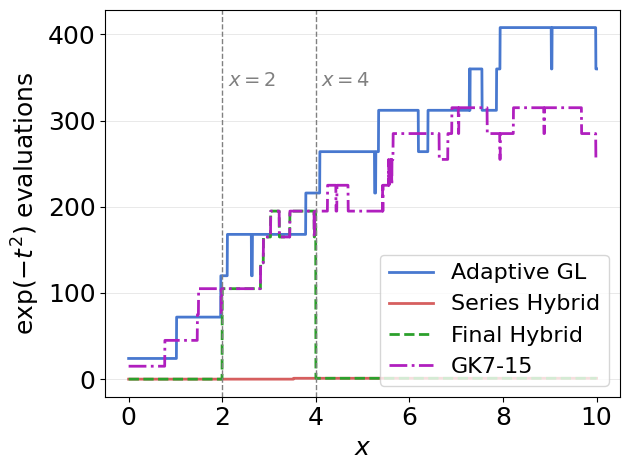

In [42]:
fig, ax = plt.subplots()

ax.plot(xs, adaptive_evals, color='#4878CF', lw=2, label='Adaptive GL')
ax.plot(xs, series_evals, color='#D65F5F', lw=2, label='Series Hybrid')
ax.plot(xs, hybrid_evals, color='#2CA02C', linestyle="--", lw=2, label='Final Hybrid')
ax.plot(xs, gk715_evals, color="#B01FBE", linestyle="-.", lw=2, label='GK7-15')
    
ax.axvline(2.0, color='grey', linestyle='--', lw=1)
ax.text(2.0 + 0.12, 340, "$x=2$", fontsize=14, color='grey')

ax.axvline(4.0, color='grey', linestyle='--', lw=1)
ax.text(4.0 + 0.12, 340, "$x=4$", fontsize=14, color='grey')

ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$\\exp(-t^2)$ evaluations', fontsize=18)

ax.legend(framealpha=0.8, fontsize=16, loc='lower right')
ax.tick_params(labelsize=18)
ax.grid(axis='y', lw=0.5, alpha=0.4)

fig.tight_layout()
# fig.savefig("evaluations.pdf")

In [43]:
series_avg = np.mean(series_evals)
adaptive_avg = np.mean(adaptive_evals)
gk715_avg = np.mean(gk715_evals)
hybrid_avg = np.mean(hybrid_evals)

series_med = np.median(series_evals)
adaptive_med = np.median(adaptive_evals)
gk715_med = np.median(gk715_evals)
hybrid_med = np.median(hybrid_evals)

In [44]:
print("Exponential evaluations\n")

print(f"Series Hybrid Mean: {series_avg:.1f}")
print(f"Adaptive GL Mean: {adaptive_avg:.1f}")
print(f"GK7-15 Mean: {gk715_avg:.1f}")
print(f"Hybrid Mean: {hybrid_avg:.1f}\n")

print(f"Series Hybrid Median: {series_med:.1f}")
print(f"Adaptive GL Median: {adaptive_med:.1f}")
print(f"GK7-15 Median: {gk715_med:.1f}")
print(f"Hybrid Median: {hybrid_med:.1f}")

Exponential evaluations

Series Hybrid Mean: 0.6
Adaptive GL Mean: 244.2
GK7-15 Mean: 204.1
Hybrid Mean: 30.7

Series Hybrid Median: 1.0
Adaptive GL Median: 264.0
GK7-15 Median: 195.0
Hybrid Median: 1.0
